In [1]:
from tqdm import tqdm_notebook
from io import open
import unicodedata
import string
import re
import random
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

DEVICE_ID = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(DEVICE_ID)
print("Device : {}".format(device))

Device : cuda


In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = len(self.index2word)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
!tail rus_eng_small.txt

она экономически независима от своих родителей .	she is economically independent of her parents .
она направила наши усилия в нужном направлении .	she steered our efforts in the right direction .
на этом заводе производят телевизоры .	they are manufacturing tv sets in this factory .
она всегда жалуется из за моей маленькой зарплаты .	she is always complaining about my small salary .
они стоят там и едят чипсы .	they are standing there and eating potato chips .
мне не удаётся скомпилировать эту программу .	i m having some problems compiling this software .
она улыбнулась в ответ на его нежный взгляд .	she smiled in response to his affectionate glance .
она проводит каждое воскресенье со своей бабушкой .	she spends time with her grandmother every sunday .
каждую субботу после обеда она играет в теннис .	she spends every saturday afternoon playing tennis .
после аварии она перестала бывать на людях .	she stopped appearing in public after her accident .


In [4]:
def readLangs():
    print("Loading dataset...")
    pairs = []
    # Read the file and split into lines
    with open('rus_eng_small.txt') as f:
        for l in tqdm_notebook(f):
            pair = [s for s in l.rstrip('\n').split('\t')]
            pairs.append(pair)

    return Lang('rus'), Lang('eng'), pairs

In [5]:
def prepareData():
    input_lang, output_lang, pairs = readLangs()
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData()
MAX_LENGTH = 10
print(random.choice(pairs))

Loading dataset...

Read 19288 sentence pairs
Counting words...
Counted words:
rus 8960
eng 3914
['меня почти не бывает дома .', 'i m hardly ever home .']


In [6]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, nlayers, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nlayers)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.nlayers, 1, self.hidden_size, device=device), \
               torch.zeros(self.nlayers, 1, self.hidden_size, device=device)

## Заполните метод вычисления аддитивного аттеншна в ячейке ниже.

готовый ноутбук слать на o.shlyazhko@corp.mail.ru

In [8]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, nlayers, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.nlayers = nlayers
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, nlayers)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn = nn.Conv2d(self.hidden_size * 2, self.hidden_size, kernel_size=1)
        self.v = nn.Conv2d(self.hidden_size, 1, kernel_size=1)
        nn.init.xavier_normal_(self.attn.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_normal_(self.v.weight)
        
        #self.dropout = nn.Dropout(dropout_p)
        #print('hidden_size: {}, nlayers: {}, output_size: {}'.format(hidden_size, nlayers, output_size))
        print('Decoder created')
        

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x) # [T2,B,C]
        #embedded = self.dropout(embedded) 
        embedded = embedded.transpose(0, 1) # [B,T2,C]
        
        encoder_outputs = encoder_outputs.transpose(0, 1) # [B,T1,C]
        #print(encoder_outputs.size(), embedded.size())
        attn_weights = self.attention(encoder_outputs, embedded)
        
        context = torch.bmm(attn_weights.transpose(1, -1), encoder_outputs)
        #print(embedded.size(), context.size())
        output = torch.cat((embedded, context), dim=-1)
        output = self.attn_combine(output).transpose(0,1)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        logits = self.out(output)
        output = F.log_softmax(logits, dim=-1)
        
        return output, hidden, attn_weights
    def attention(self, encoder_outputs, embedded):
        # encoder_outputs size [B,T1,C]; embedded size [B,T2,C]
        T1 = encoder_outputs.size(1)
        T2 = embedded.size(1)
        
        embedded_expand = embedded.expand(T1, -1, -1)
        embedded_expand = embedded_expand.transpose(0, 1)
        encoder_expand = encoder_outputs.expand(T2, -1, -1)
        energy = torch.cat((embedded_expand, encoder_expand), dim = -1)
        
        energy = energy.transpose(0, -1).unsqueeze(0) # [1,C,T1,T2]
            
        energy = self.v(torch.tanh(self.attn(energy))) # [1,1,T1,T2]
        energy.squeeze_(0)
        energy = F.softmax(energy, dim = -2) # [1,T1,T2]
        return energy
        
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
def train(input_tensor, target_tensor, 
          encoder, decoder, 
          optimizer,  criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    if teacher_forcing_ratio == 1.: # use fast parallel mode
        decoder_input = torch.cat([decoder_input, target_tensor[:-1]], dim=0)
        decoder_outputs, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
        decoder_outputs = decoder_outputs.squeeze()
        loss += criterion(decoder_outputs, target_tensor.squeeze())
        loss_value = loss.item()
    else:
        for di in range(target_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            loss += criterion(decoder_output, target_tensor[di])
            if use_teacher_forcing:
                decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            else:
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.detach()
        loss_value =  loss.item() / target_length

    loss.backward()

    optimizer.step()

    return loss_value

In [10]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [11]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [12]:
def run_training(encoder, decoder, n_iters, print_every=1000, plot_every=100):
    print('Train')
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    for iter in tqdm_notebook(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            dt = time_since(start, iter / n_iters)
            print('%s (%d %d%%) %.4f' % (dt, iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden # STATE TRANSFER
    
        decoded_words = []
        decoder_attentions = []
        for di in range(max_length):
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention)
            decoder_output = decoder_output.view(decoder_output.size(0), -1)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            if topi.item() == EOS_token:
                break
            word = output_lang.index2word[topi.item()]
            decoded_words.append(word)

        return decoded_words, decoder_attentions

In [14]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [15]:
n_iters=100000
training_pairs = [tensorsFromPair(random.choice(pairs)) for i in tqdm_notebook(range(n_iters), desc='prepare set')]

In [16]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, 1, hidden_size).to(device)
decoder = AttnDecoder(hidden_size, 1, output_lang.n_words, dropout_p=0.1).to(device)

Decoder created


In [17]:
teacher_forcing_ratio = 1.
learning_rate=0.001
optimizer = optim.Adam(list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate)
criterion = nn.NLLLoss()

Train
0m 10s (- 11m 48s) (1500 1%) 3.1167
0m 21s (- 11m 34s) (3000 3%) 2.5540
0m 32s (- 11m 36s) (4500 4%) 2.3499
0m 43s (- 11m 14s) (6000 6%) 2.2465
0m 53s (- 11m 5s) (7500 7%) 2.0802
1m 4s (- 10m 49s) (9000 9%) 2.0419
1m 14s (- 10m 38s) (10500 10%) 1.9460
1m 24s (- 10m 22s) (12000 12%) 1.8772
1m 35s (- 10m 9s) (13500 13%) 1.7708
1m 45s (- 10m 0s) (15000 15%) 1.7644
1m 55s (- 9m 46s) (16500 16%) 1.7247
2m 5s (- 9m 33s) (18000 18%) 1.6561
2m 16s (- 9m 22s) (19500 19%) 1.6860
2m 26s (- 9m 10s) (21000 21%) 1.5971
2m 37s (- 9m 1s) (22500 22%) 1.5594
2m 48s (- 8m 52s) (24000 24%) 1.4846
2m 57s (- 8m 40s) (25500 25%) 1.5228
3m 8s (- 8m 29s) (27000 27%) 1.4489
3m 19s (- 8m 20s) (28500 28%) 1.4378
3m 29s (- 8m 9s) (30000 30%) 1.3929
3m 39s (- 7m 58s) (31500 31%) 1.3290
3m 50s (- 7m 47s) (33000 33%) 1.3444
4m 1s (- 7m 38s) (34500 34%) 1.3417
4m 11s (- 7m 27s) (36000 36%) 1.2687
4m 22s (- 7m 16s) (37500 37%) 1.2323
4m 32s (- 7m 6s) (39000 39%) 1.2495
4m 43s (- 6m 56s) (40500 40%) 1.2376
4m 55s 

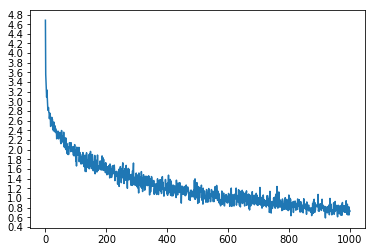

In [18]:
run_training(encoder, decoder, n_iters, print_every=1500)

In [19]:
evaluate_randomly(encoder, decoder)

> я так взбешен .
= i m so mad .
< i m so frightened .

> мы не американцы .
= we are not americans .
< we re not together .

> я не здешний .
= i m not from here .
< i m not a loser .

> мне столько же лет .
= i am the same age .
< i m as old as you .

> вы самодовольные .
= you re vain .
< you re vain .

> сейчас я читаю книгу .
= i am reading a book now .
< i m reading a book now .

> они все умирают .
= they re all dying .
< they are all waiting .

> я готовлюсь к выходу .
= i m getting ready to go out .
< i m getting ready to go out .

> мы так признательны .
= we re so grateful .
< we re so grateful .

> ты упрямый .
= you re obstinate .
< you re obstinate .



input = я очень осторожна .
output = i m very careful .


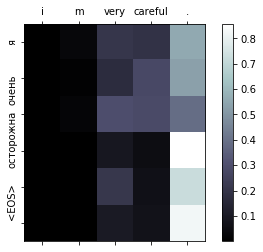

input = они всё ещё живут со своими родителями .
output = they are still waiting for their .


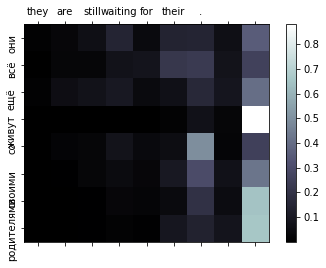

In [20]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_yticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    attentions = torch.cat(attentions).squeeze().cpu()
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("я очень осторожна .")
evaluateAndShowAttention("они всё ещё живут со своими родителями .")

In [22]:
torch.save(encoder, './model_encoder')
torch.save(encoder.state_dict(), './state_encoder')
torch.save(decoder, './model_decoder')
torch.save(decoder.state_dict(), './state_decoder')

/home/a.chesnov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/a.chesnov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type AttnDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
